# Анализ методов кластеризации на примере изображения

## Загрузка изображения

In [ ]:
import requests
import io
import cv2
from PIL import Image
import time
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import Birch

In [ ]:
def get_size(image_array, filename="temp.png"):
    """
    Сохраняет изображение в формате PNG (без потерь) и возвращает его размер в КБ.
    - image_array: NumPy-массив или PIL.Image.
    """
    # Преобразуем в NumPy, если это PIL.Image
    if not isinstance(image_array, np.ndarray):
        image_array = np.array(image_array)

    # Приводим к uint8, если нужно
    if image_array.dtype != np.uint8:
        image_array = image_array.astype(np.uint8)

    # Преобразуем в PIL.Image и сохраняем в PNG
    img_pil = Image.fromarray(image_array)
    img_pil.save(filename, format="PNG")

    # Получаем размер файла в КБ
    file_size_kb = os.path.getsize(filename) / 1024

    # Удаляем временный файл
    os.remove(filename)

    return file_size_kb

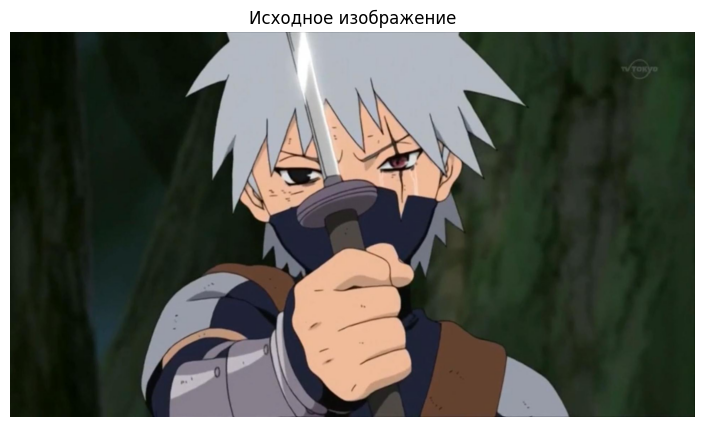

Размер загруженного изображения: 83.37 КБ
Разрешение изображения: 1920x1080 пикселей
Размер оригинала: 752.56 КБ


In [ ]:
# URL изображения
image_url = "https://drive.google.com/uc?id=1PsmhUCI3CO33uBAziJzM-Rly4n4T-vcr"

# Загрузка изображения
response = requests.get(image_url)
image_bytes = io.BytesIO(response.content)

# Открытие изображения
image = Image.open(image_bytes)
image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)  # Преобразование в OpenCV-формат (BGR)

# Вывод изображения
plt.figure(figsize=(10, 5))
plt.imshow(image)
plt.axis("off")
plt.title("Исходное изображение")
plt.show()

# Вычисление размера файла в памяти (в байтах)
image_size = len(response.content)
print(f"Размер загруженного изображения: {image_size / 1024:.2f} КБ")

# Определение разрешения
width, height = image.size
print(f"Разрешение изображения: {width}x{height} пикселей")

print(f"Размер оригинала: {get_size(image):.2f} КБ")

In [ ]:
# Создаём DataFrame с колонками
results_df = pd.DataFrame(columns=["Метод", "Размер изображения (КБ)", "Затраченное время (с)", "Экспертная оценка"])

# Добавляем исходное изображение
original_data = pd.DataFrame([{
    "Метод": "Original",
    "Размер изображения (КБ)": get_size(image),
    "Затраченное время (с)": 0,
    "Экспертная оценка": 10
}])

# Объединяем данные
results_df = pd.concat([results_df, original_data], ignore_index=True)

results_df

<ipython-input-4-0c4d45fcf36e>:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, original_data], ignore_index=True)


,Метод,Размер изображения (КБ),Затраченное время (с),Экспертная оценка
0,Original,752.556641,0,10


## Подготовка данных

In [ ]:
# Преобразование изображения в массив
image_array = np.array(image)  # Преобразуем в numpy-массив
h, w, c = image_array.shape  # Получаем высоту, ширину и число каналов
pixels = image_array.reshape(-1, 3)  # Разворачиваем в массив пикселей

print(f"Размер изображения: {h}x{w}")
print(f"Общее количество пикселей: {pixels.shape[0]}")
print(f"Форма массива пикселей: {pixels.shape}")

Размер изображения: 1080x1920
Общее количество пикселей: 2073600
Форма массива пикселей: (2073600, 3)


Масштабирование:
- Масштабирование улучшает работу алгоритмов, основанных на расстояниях
- Алгоритмы, использующие плотность, чувствительны к масштабу
- Масштабирование ускоряет сходимость алгоритмов (например, центроиды быстрее сходятся к оптимальным позициям)
- Позволяет корректно сравнивать разные признаки (например, каналы могут иметь разные диапазоны значений)

`MinMaxScaler` выбран, так как он сохраняет соотношение между пикселями и удобен для алгоритмов, работающих с расстояниями. `StandardScaler` больше подходит для методов, работающих со статистическими распределениями (например, `PCA`)

In [ ]:
# Нормализация данных в диапазоне [0, 1]
scaler = MinMaxScaler()
pixels_norm = scaler.fit_transform(pixels)

## K-means

Как работает:
1. Задаётся количество кластеров K.
2. Инициализируются K случайных центроидов (средних значений кластеров).
3. Каждый пиксель привязывается к ближайшему центроиду (по евклидову расстоянию).
4. Обновляются центроиды – вычисляется новое среднее значение цвета для каждого кластера.
5. Повторяем шаги 3-4, пока центроиды не перестанут сильно изменяться.


Гиперпараметры и их выбор:
- `n_clusters` (число кластеров) – Подберем оптимальное с помощью метода локтя.
- `n_init` (количество инициализаций центроидов) – Количество раз, когда алгоритм `k-means` запускается с разными начальными центроидами. Конечные результаты являются наилучшими с точки зрения инерционности при `n_init` последовательных запусках. Чтобы избежать плохой инициализации.
- `random_state=42` – Определяет генерацию случайных чисел для инициализации центроида, для воспроизводимости результатов.

Метод логтя.

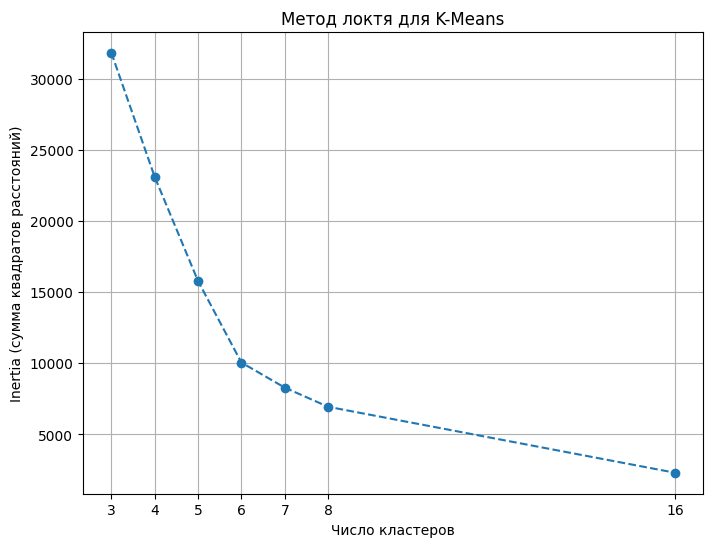

In [ ]:
# Определяем диапазон количества кластеров
cluster_range = [3, 4, 5, 6, 7, 8, 16]
inertia_values = []

# Применение K-Means и расчет inertia
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(pixels_norm)
    inertia_values.append(kmeans.inertia_)

# График метода локтя
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='--')
plt.xlabel("Число кластеров")
plt.ylabel("Inertia (сумма квадратов расстояний)")
plt.title("Метод локтя для K-Means")
plt.xticks(cluster_range)
plt.grid()
plt.show()

Время выполнения K-Means: 38.8893 секунд
Размер результирующего изображения в памяти: 153.7324 КБ


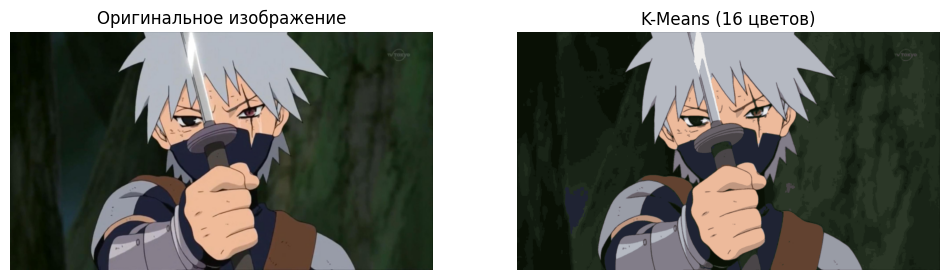

In [ ]:
optimal_k = 16

# Запуск таймера
start_time = time.time()

# Запуск K-Means с 6 кластерами
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(pixels_norm)  # Определяем кластеры для пикселей
centroids = scaler.inverse_transform(kmeans.cluster_centers_)  # Возвращаем цвета в оригинальный диапазон

# Создаём новое изображение
clustered_image = centroids[labels].reshape(h, w, c).astype(np.uint8)

# Остановка таймера
end_time = time.time()
execution_time = end_time - start_time

# Вычисление размера результирующего изображения в памяти (в байтах)
# image_size_bytes = clustered_image.nbytes

# Вывод результатов
print(f"Время выполнения K-Means: {execution_time:.4f} секунд")
print(f"Размер результирующего изображения в памяти: {get_size(clustered_image):.4f} КБ")

# Визуализация результата: оригинал vs кластеризованное изображение
plt.figure(figsize=(12, 5))

# Оригинальное изображение
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis("off")
plt.title("Оригинальное изображение")

# Кластеризованное изображение
plt.subplot(1, 2, 2)
plt.imshow(clustered_image)
plt.axis("off")
plt.title(f"K-Means ({optimal_k} цветов)")

plt.show()

Время выполнения K-Means: 11.7723 секунд
Размер результирующего изображения в памяти: 70.8984 КБ


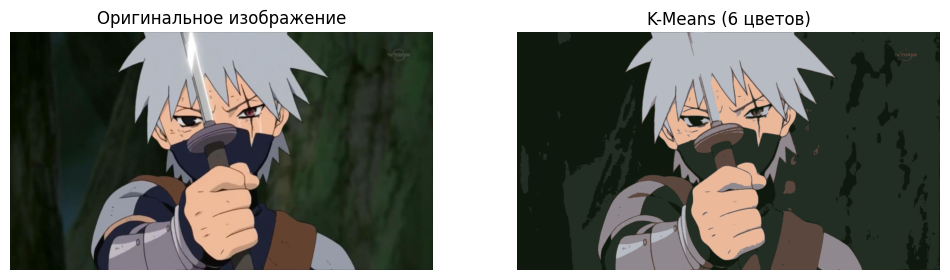

In [ ]:
optimal_k = 6

# Запуск таймера
start_time = time.time()

# Запуск K-Means с 6 кластерами
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(pixels_norm)  # Определяем кластеры для пикселей
centroids = scaler.inverse_transform(kmeans.cluster_centers_)  # Возвращаем цвета в оригинальный диапазон

# Создаём новое изображение
clustered_image = centroids[labels].reshape(h, w, c).astype(np.uint8)

# Остановка таймера
end_time = time.time()
execution_time = end_time - start_time

# Вычисление размера результирующего изображения в памяти (в байтах)
# image_size_bytes = clustered_image.nbytes

# Вывод результатов
print(f"Время выполнения K-Means: {execution_time:.4f} секунд")
print(f"Размер результирующего изображения в памяти: {get_size(clustered_image):.4f} КБ")

# Визуализация результата: оригинал vs кластеризованное изображение
plt.figure(figsize=(12, 5))

# Оригинальное изображение
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis("off")
plt.title("Оригинальное изображение")

# Кластеризованное изображение
plt.subplot(1, 2, 2)
plt.imshow(clustered_image)
plt.axis("off")
plt.title(f"K-Means ({optimal_k} цветов)")

plt.show()

In [ ]:
# Добавляем K-Means
kmeans_data = pd.DataFrame([{
    "Метод": f"K-Means ({optimal_k} кластеров)",
    "Размер изображения (КБ)": get_size(clustered_image),
    "Затраченное время (с)": execution_time,
    "Экспертная оценка": 6
}])

# Объединяем данные
results_df = pd.concat([results_df, kmeans_data], ignore_index=True)
results_df

,Метод,Размер изображения (КБ),Затраченное время (с),Экспертная оценка
0,Original,752.556641,0,10
1,K-Means (6 кластеров),70.898438,11.772297,6


## MeanShift

Как работает:
1. Выбирается окно (радиус `bandwidth`), в котором ищется максимальная плотность точек (пикселей).
2. Пиксели притягиваются к центрам плотности, создавая естественные кластеры.
3. Процесс повторяется, пока кластеры не стабилизируются.

Гиперпараметры и их выбор:
- `bandwidth` (размер окна) – оценим автоматически с помощью `estimate_bandwidth()`.
- `bin_seeding=True` – ускоряет алгоритм за счёт использования сетки точек. Вместо того, чтобы начинать с каждого пикселя, MeanShift разбивает пространство на сетку (bins). Выбирает только самые плотные точки в этой сетке как начальные центроиды.

`quantile=0.2` означает, что `bandwidth` будет таким, что 20% ближайших точек попадут в один кластер.

При 0.3 получается мало кластеров. При 0.1 - 8 кластеров, качество примерно как у 0.2, даже немного хуже.

Используемый bandwidth: 0.0503
Число кластеров, найденных MeanShift: 25
Размер получившегося изображения: 152.2900390625 KB


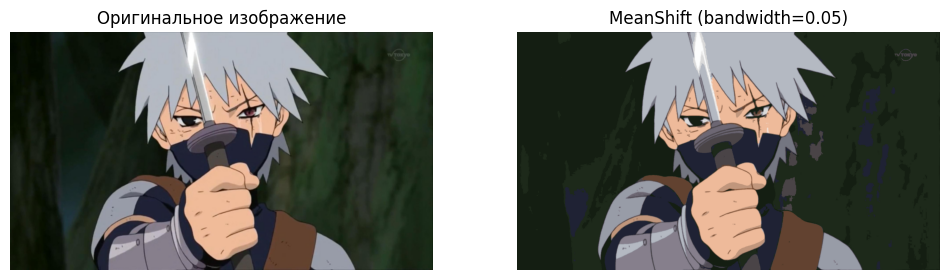

In [ ]:
# Оценка bandwidth
bandwidth = estimate_bandwidth(pixels_norm, quantile=0.05, n_samples=10000)
print(f"Используемый bandwidth: {bandwidth:.4f}")

# Запуск таймера
start_time = time.time()

# Запуск MeanShift
meanshift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
labels = meanshift.fit_predict(pixels_norm)  # Определяем кластеры
centroids = scaler.inverse_transform(meanshift.cluster_centers_)  # Возвращаем цвета в оригинальный диапазон

# Создание нового изображения
clustered_image_meanshift = centroids[labels].reshape(h, w, c).astype(np.uint8)

# Остановка таймера
end_time = time.time()
execution_time_meanshift = end_time - start_time

# Количество кластеров
num_clusters = len(centroids)
print(f"Число кластеров, найденных MeanShift: {num_clusters}")

# Размер
print(f"Размер получившегося изображения: {get_size(clustered_image_meanshift)} KB")

# Визуализация: оригинал vs кластеризованное изображение
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis("off")
plt.title("Оригинальное изображение")

plt.subplot(1, 2, 2)
plt.imshow(clustered_image_meanshift)
plt.axis("off")
plt.title(f"MeanShift (bandwidth={bandwidth:.2f})")

plt.show()

Используемый bandwidth: 0.1486
Число кластеров, найденных MeanShift: 6
Размер получившегося изображения: 47.59765625 KB


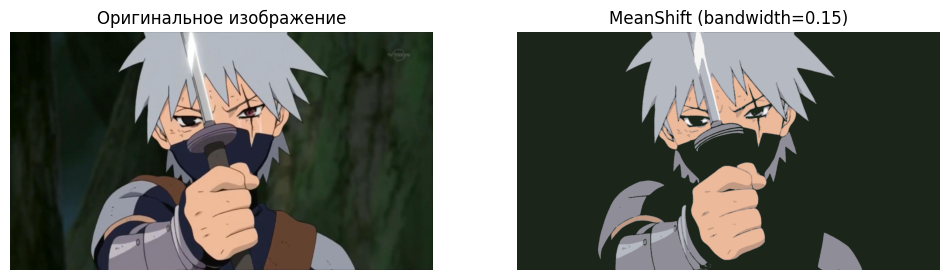

In [ ]:
# Оценка bandwidth
bandwidth = estimate_bandwidth(pixels_norm, quantile=0.2, n_samples=10000)
print(f"Используемый bandwidth: {bandwidth:.4f}")

# Запуск таймера
start_time = time.time()

# Запуск MeanShift
meanshift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
labels = meanshift.fit_predict(pixels_norm)  # Определяем кластеры
centroids = scaler.inverse_transform(meanshift.cluster_centers_)  # Возвращаем цвета в оригинальный диапазон

# Создание нового изображения
clustered_image_meanshift = centroids[labels].reshape(h, w, c).astype(np.uint8)

# Остановка таймера
end_time = time.time()
execution_time_meanshift = end_time - start_time

# Количество кластеров
num_clusters = len(centroids)
print(f"Число кластеров, найденных MeanShift: {num_clusters}")

# Размер
print(f"Размер получившегося изображения: {get_size(clustered_image_meanshift)} KB")

# Визуализация: оригинал vs кластеризованное изображение
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis("off")
plt.title("Оригинальное изображение")

plt.subplot(1, 2, 2)
plt.imshow(clustered_image_meanshift)
plt.axis("off")
plt.title(f"MeanShift (bandwidth={bandwidth:.2f})")

plt.show()

In [ ]:
# Добавляем в DataFrame
meanshift_data = pd.DataFrame([{
    "Метод": f"MeanShift ({num_clusters} кластеров)",
    "Размер изображения (КБ)": get_size(clustered_image_meanshift),
    "Затраченное время (с)": execution_time_meanshift,
    "Экспертная оценка": 5
}])

results_df = pd.concat([results_df, meanshift_data], ignore_index=True)
results_df

,Метод,Размер изображения (КБ),Затраченное время (с),Экспертная оценка
0,Original,752.556641,0,10
1,K-Means (6 кластеров),70.898438,11.772297,6
2,MeanShift (6 кластеров),47.597656,43.023024,5


## Birch

Как работает:
1. Строит компактную иерархическую структуру (CF-Tree) для кластеризации данных.
2. Использует пороговое расстояние (`threshold`), чтобы объединять похожие пиксели.
3. Если порог превышен, создаёт новый подкластер.
4. В конце сжимает дерево, создавая итоговые кластеры.

Гиперпараметры и их выбор:

`threshold` – радиус объединения точек в подкластер
- Если threshold маленький, BIRCH создаёт много мелких кластеров.
- Если threshold большой, кластеры будут крупнее, но могут сливаться.
- Обычно выбирают threshold от 0.01 до 0.5.

Экспериментально получилось: оптимально 0.1-0.15 без указания числа кластеров. При 0.05 получается неоптимально по памяти, при 0.2 - мало кластеров.

`branching_factor` – максимальное число подкластеров в узле CF-Tree
- Чем больше, тем глубже дерево.
- Обычно 50–100 – разумный баланс.

`n_clusters=None` – позволили алгоритму самостоятельно определить число кластеров.

Число кластеров, найденных BIRCH: 48
Размер получившегося изображения: 249.66015625 KB


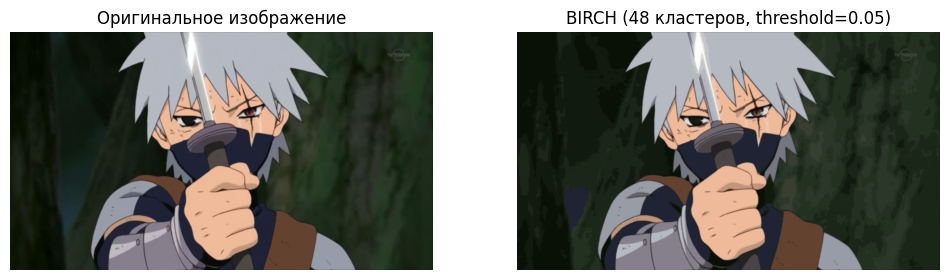

In [ ]:
# Гиперпараметры BIRCH
threshold = 0.05  # Радиус объединения точек

# Запуск таймера
start_time = time.time()

# Запуск BIRCH без явного указания количества кластеров
birch = Birch(threshold=threshold, n_clusters=None, branching_factor=50)
labels = birch.fit_predict(pixels_norm)  # Получаем кластеры

# Количество найденных кластеров
num_clusters_birch = len(np.unique(labels))
print(f"Число кластеров, найденных BIRCH: {num_clusters_birch}")

# Определяем центроиды (средний цвет в каждом кластере)
centroids = np.array([pixels[labels == i].mean(axis=0) for i in range(num_clusters_birch)])

# Создаём новое изображение
clustered_image_birch = centroids[labels].reshape(h, w, c).astype(np.uint8)

# Остановка таймера
end_time = time.time()
execution_time_birch = end_time - start_time

# Вычисление размера изображения в памяти
image_size_bytes_birch = clustered_image_birch.nbytes

print(f"Размер получившегося изображения: {get_size(clustered_image_birch)} KB")

# Визуализация: оригинал vs кластеризованное изображение
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis("off")
plt.title("Оригинальное изображение")

plt.subplot(1, 2, 2)
plt.imshow(clustered_image_birch)
plt.axis("off")
plt.title(f"BIRCH ({num_clusters_birch} кластеров, threshold={threshold})")

plt.show()

Размер получившегося изображения: 50.9736328125 KB


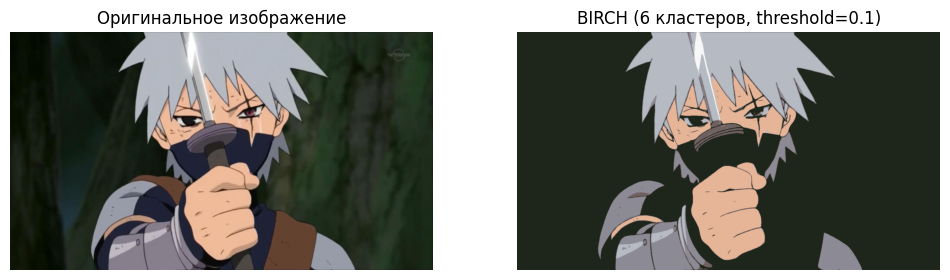

In [ ]:
# Гиперпараметры BIRCH
num_clusters_birch = 6  # Количество кластеров (для сравнения с другими методами)
threshold = 0.1  # Радиус объединения (0.15 уже хуже качество)

# Запуск таймера
start_time = time.time()

# Запуск BIRCH
birch = Birch(threshold=threshold, n_clusters=num_clusters_birch, branching_factor=50)
labels = birch.fit_predict(pixels_norm)  # Получаем кластеры

# Определяем центроиды кластеров
centroids = np.array([pixels[labels == i].mean(axis=0) for i in range(num_clusters_birch)])

# Создаём новое изображение
clustered_image_birch = centroids[labels].reshape(h, w, c).astype(np.uint8)

# Остановка таймера
end_time = time.time()
execution_time_birch = end_time - start_time

# Вычисление размера изображения в памяти
image_size_bytes_birch = clustered_image_birch.nbytes

print(f"Размер получившегося изображения: {get_size(clustered_image_birch)} KB")

# Визуализация: оригинал vs кластеризованное изображение
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis("off")
plt.title("Оригинальное изображение")

plt.subplot(1, 2, 2)
plt.imshow(clustered_image_birch)
plt.axis("off")
plt.title(f"BIRCH ({num_clusters_birch} кластеров, threshold={threshold})")

plt.show()

In [ ]:
# Добавляем в DataFrame
birch_data = pd.DataFrame([{
    "Метод": f"BIRCH ({num_clusters_birch} кластеров)",
    "Размер изображения (КБ)": get_size(clustered_image_birch),
    "Затраченное время (с)": execution_time_birch,
    "Экспертная оценка": 5
}])

results_df = pd.concat([results_df, birch_data], ignore_index=True)
results_df

,Метод,Размер изображения (КБ),Затраченное время (с),Экспертная оценка
0,Original,752.556641,0,10
1,K-Means (6 кластеров),70.898438,11.772297,6
2,MeanShift (6 кластеров),47.597656,43.023024,5
3,BIRCH (6 кластеров),50.973633,29.056288,5


## DBSCAN

Как работает:
1. Для каждой точки ищем соседей в радиусе `eps`.
2. Если точек больше `min_samples`, создаём новый кластер.
3. Если точка не имеет достаточного количества соседей, считаем её шумом.
4. Алгоритм продолжает объединять точки, пока не найдёт все кластеры.

Гиперпараметры и их выбор:
1. `eps` (радиус для поиска соседей)
  - Определяет, насколько далеко могут находиться точки, чтобы быть в одном кластере.
  - Чем меньше `eps`, тем меньше кластеров (и больше шумовых точек).
  - Чем больше `eps`, тем больше объединение (слияние кластеров).
  - Обычно подбирается методом `kneighbors` (см. ниже).

2. `min_samples` (минимальное число точек в кластере)
  - Если у точки меньше `min_samples` соседей, она считается шумом.
  - Значение `min_samples` обычно равно `2 * n_features` (для RGB `min_samples ≈ 6`).

Чтобы определить `eps`, используется метод `k-nearest neighbors` (kNN plot):
1. Считаем расстояния до ближайших `min_samples` соседей.
2. Строим график и ищем "излом" (`elbow point`).
3. Значение на изломе – рекомендуемый `eps`.

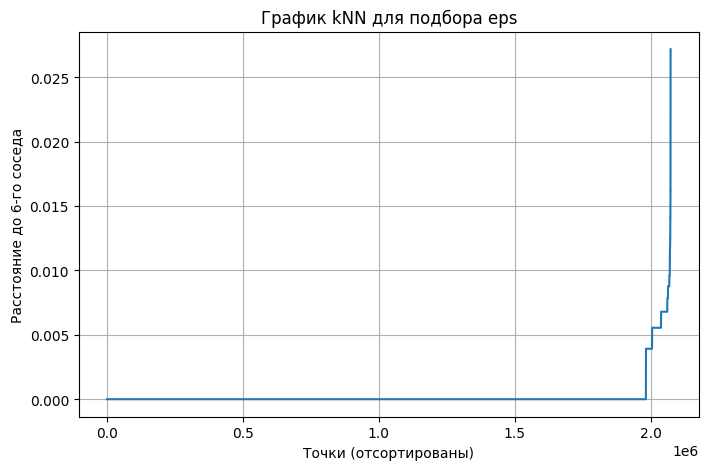

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Определение числа соседей (обычно 2 * число признаков, то есть 6 для RGB)
min_samples = 6

# Используем 6 ближайших соседей
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors.fit(pixels_norm)
distances, _ = neighbors.kneighbors(pixels_norm)

# Берем расстояния до 6-го ближайшего соседа и сортируем
distances = np.sort(distances[:, -1])

# Строим график
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.xlabel("Точки (отсортированы)")
plt.ylabel("Расстояние до 6-го соседа")
plt.title("График kNN для подбора eps")
plt.grid()
plt.show()

In [ ]:
# Убеждаемся, что изображение в формате NumPy-массива
if not isinstance(image, np.ndarray):
    image = np.array(image)

# Уменьшаем изображение до 50% (можно 25%, если нужно ещё меньше)
scale_percent = 50  # Масштаб
new_width = int(image.shape[1] * scale_percent / 100)
new_height = int(image.shape[0] * scale_percent / 100)

# Масштабируем изображение
image_resized = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

# Преобразуем в массив пикселей и нормализуем
pixels_resized = image_resized.reshape(-1, 3) / 255.0  # Разворачиваем и нормализуем
print(f"Новое разрешение: {new_width}x{new_height}, число пикселей: {pixels_resized.shape[0]}")

Новое разрешение: 960x540, число пикселей: 518400


Число кластеров, найденных DBSCAN: 1560
Число шумовых точек: 30963
Размер уменьшенного изображения: 305.6787109375 КБ
Размер кластеризированного изображения: 106.8779296875 КБ


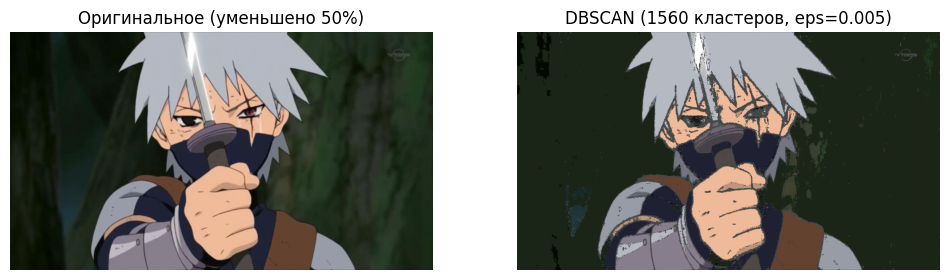

In [ ]:
from sklearn.cluster import DBSCAN

# Параметры DBSCAN (eps подставляем после графика)
eps_value = 0.005  # Подставить найденное значение
min_samples = 6  # Оставляем, как есть

# Запуск таймера
start_time = time.time()

# Запуск DBSCAN на уменьшенном изображении
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples)
labels = dbscan.fit_predict(pixels_resized)

# Количество кластеров (без шума)
num_clusters_dbscan = len(set(labels)) - (1 if -1 in labels else 0)
num_noise = list(labels).count(-1)
print(f"Число кластеров, найденных DBSCAN: {num_clusters_dbscan}")
print(f"Число шумовых точек: {num_noise}")

# Определяем центроиды (средний цвет в каждом кластере)
centroids = np.array([pixels_resized[labels == i].mean(axis=0) for i in range(num_clusters_dbscan)])

# Создаём новое изображение
clustered_image_dbscan = centroids[labels].reshape(new_height, new_width, 3)
clustered_image_dbscan = (clustered_image_dbscan * 255).astype(np.uint8)

# Остановка таймера
end_time = time.time()
execution_time_dbscan = end_time - start_time

# Вычисление размера изображения в памяти
image_size_bytes_dbscan = clustered_image_dbscan.nbytes

# Размеры
print(f"Размер уменьшенного изображения: {get_size(image_resized)} КБ")
print(f"Размер кластеризированного изображения: {get_size(clustered_image_dbscan)} КБ")

# Визуализация: оригинал vs кластеризованное изображение
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_resized)
plt.axis("off")
plt.title(f"Оригинальное (уменьшено {scale_percent}%)")

plt.subplot(1, 2, 2)
plt.imshow(clustered_image_dbscan)
plt.axis("off")
plt.title(f"DBSCAN ({num_clusters_dbscan} кластеров, eps={eps_value})")

plt.show()

In [ ]:
# Добавляем в DataFrame
dbscan_data = pd.DataFrame([{
    "Метод": "DBSCAN",
    "Размер изображения (КБ)": get_size(clustered_image_dbscan),
    "Затраченное время (с)": execution_time_dbscan,
    "Экспертная оценка": 3
}])

results_df = pd.concat([results_df, dbscan_data], ignore_index=True)
results_df

,Метод,Размер изображения (КБ),Затраченное время (с),Экспертная оценка
0,Original,752.556641,0,10
1,K-Means (6 кластеров),70.898438,11.772297,6
2,MeanShift (6 кластеров),47.597656,43.023024,5
3,BIRCH (6 кластеров),50.973633,29.056288,5
4,DBSCAN,106.877930,49.598845,3


## Результаты

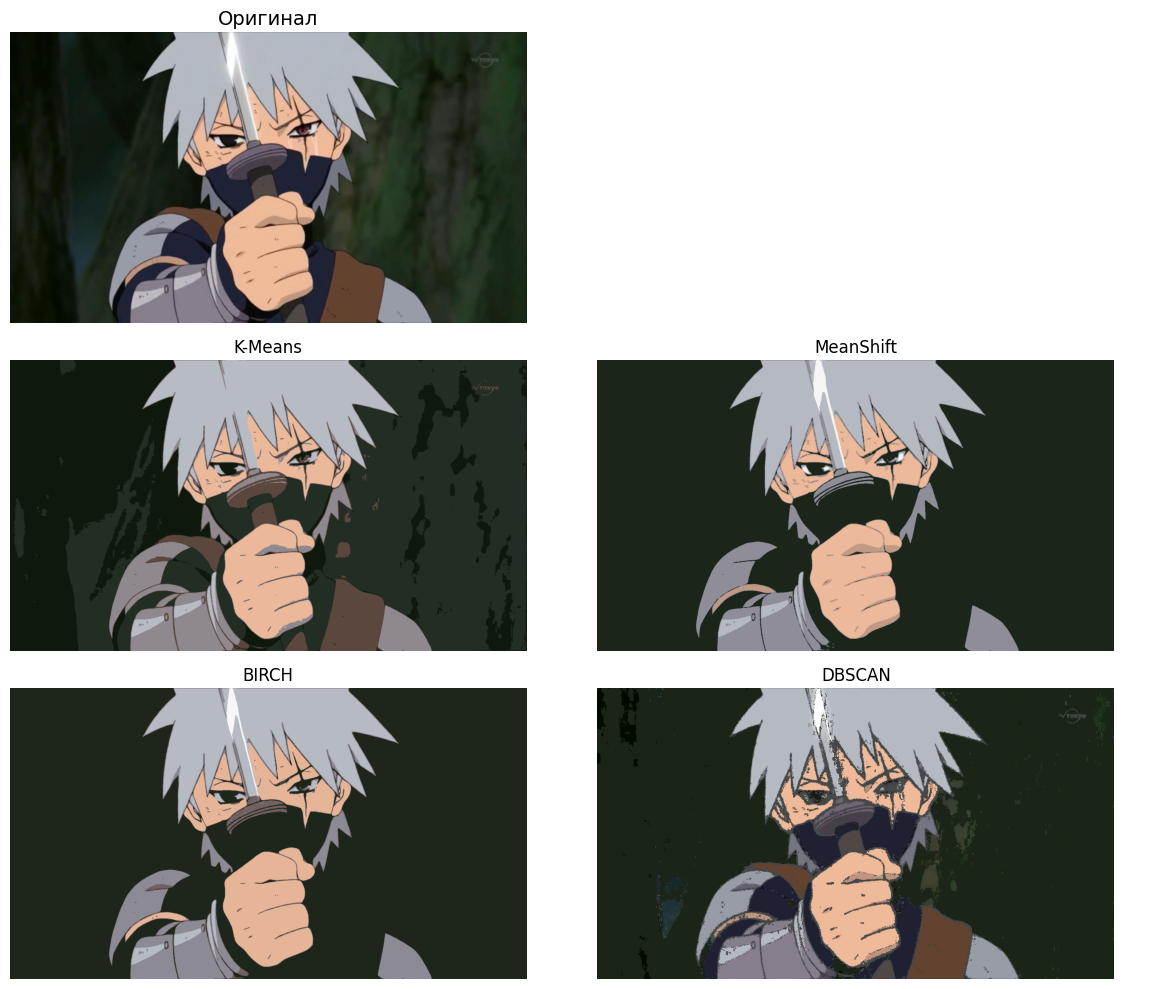

In [ ]:
# Создаём фигуру с 3 строками (1+2+2)
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

# Первая строка: оригинальное изображение (по центру)
axes[0, 0].imshow(image)
axes[0, 0].axis("off")
axes[0, 0].set_title("Оригинал", fontsize=14)
axes[0, 1].axis("off")  # Пуста ячейка для выравнивания

# Вторая строка: K-Means и MeanShift
axes[1, 0].imshow(clustered_image)
axes[1, 0].axis("off")
axes[1, 0].set_title("K-Means", fontsize=12)

axes[1, 1].imshow(clustered_image_meanshift)
axes[1, 1].axis("off")
axes[1, 1].set_title("MeanShift", fontsize=12)

# Третья строка: BIRCH и DBSCAN
axes[2, 0].imshow(clustered_image_birch)
axes[2, 0].axis("off")
axes[2, 0].set_title("BIRCH", fontsize=12)

axes[2, 1].imshow(clustered_image_dbscan)
axes[2, 1].axis("off")
axes[2, 1].set_title("DBSCAN", fontsize=12)

# Выравниваем отступы и показываем изображение
plt.tight_layout()
plt.show()


In [ ]:
results_df

,Метод,Размер изображения (КБ),Затраченное время (с),Экспертная оценка
0,Original,752.556641,0,10
1,K-Means (6 кластеров),70.898438,11.772297,6
2,MeanShift (6 кластеров),47.597656,43.023024,5
3,BIRCH (6 кластеров),50.973633,29.056288,5
4,DBSCAN,106.877930,49.598845,3
